In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")

### Refractory Poisson

There are two ways to simulate it: with the GLM framework or with the time-rescaled renewal processes

In [3]:
import neuroprob as mdl
from neuroprob import utils

dev = utils.pytorch.get_device() # PyTorch device

PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [53]:
tbin = 0.001
Tsteps = 1000
refracts = [0.0, 0.001, 0.002, 0.004]
rp = np.ones((10000, 1, Tsteps))
cnts = []
rate_n = 10

for refract in refracts:
    for rate in np.linspace(1, 30, rate_n):
        ISI_dist = mdl.point_process.ISI_gamma(np.ones(1), loc=rate*refract)
        spike_ind = mdl.point_process.gen_IRP(ISI_dist, rate*rp, tbin)
        cnts.append(np.array([len(s) for s in spike_ind]))

In [54]:
cnts = np.array(cnts).reshape(len(refracts), rate_n, -1)

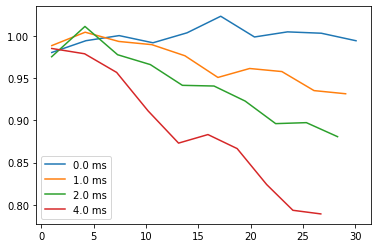

In [55]:
for k, r in enumerate(refracts):
    plt.plot(cnts.mean(-1)[k, :], (cnts.var(-1)/cnts.mean(-1))[k, :], label='{} ms'.format(r*1000))
    
plt.legend()

In [ ]:
# IPP-GLM with refractory
T = 50000
runs = 10

#T_int = 0
I_ext = np.zeros((runs, T))

sample_bin = 0.001
        
for r in range(runs):    
    I_ext[r, :] = r/5.


In [ ]:
hist_len = 100
VI_tuples = [(None, None, None, 1)]
covariates = [I_ext[:, :, None]]

input_group = mdl.inference.input_group(1, VI_tuples, stimulus_filter=None)
input_group.set_XZ(covariates, T, batch_size=5000, filter_len=hist_len, trials=runs)



# GLM validation with synthetic GLM data
#ivlink = 'exp'
ivlink = lambda x: torch.sigmoid(x)/sample_bin

glm_rate = mdl.parametrics.GLM(1, 1, 1, ivlink, bias=True)
glm_rate.set_params(np.array([[1.0]]), np.array([[-5.0]]))

_likelihood = mdl.likelihoods.Bernoulli(sample_bin, 1, ivlink)

syn_trains = []
taus = [0., 1., 2., 4.]
for tau_ in taus:
    a = np.array([[[-10.0]]])
    beta = np.array([[[10.0]]])
    tau = np.array([[[tau_]]])

    #hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.sigmoid_refractory(a=a, beta=beta, tau=tau, timesteps=hist_len-1, 
                                                 learnable=[False, False, False])


    likelihood = mdl.filters.filtered_likelihood(_likelihood, hist_couple)


    glm = mdl.inference.VI_optimized(input_group, glm_rate, likelihood)
    glm.to(dev)


    ini_train = np.zeros((10, 1, hist_len-2))
    MC = 1

    F_mu = glm.sample_F(covariates, MC=MC, F_dims=np.arange(1), trials=runs)
    syn_train, rate = glm.likelihood.sample(F_mu[None, ...], ini_train)
    
    syn_trains.append(syn_train)

In [ ]:
ss = []
for syn_train_ in syn_trains:
    ss.append(syn_train_.reshape(10, 5000, 10).sum(-1))

In [ ]:
ts =  [0, 1, 3]

for t in ts:
    ms = ss[t].mean(-1)
    plt.plot(ms/sample_bin/10)
    
plt.show()


for t in ts:
    ms = ss[t].mean(-1)
    vs = ss[t].var(-1)
    plt.plot(ms/sample_bin/10, vs/(ms+1e-12), label='{} ms'.format(int(taus[t])))
    
plt.ylabel('Fano factor')
plt.xlabel('firing rate (Hz)')
plt.legend()
plt.show()

In [ ]:
aa = np.where(syn_train[0, 0, :] != 0)[0]
plt.scatter(aa, np.zeros_like(aa))
plt.show()


a_t = hist_couple.compute_filter()
plt.plot(a_t.cpu().numpy()[0, 0, ::-1])

### Renewal process likelihood
Here we visualize the loss landscape for a renewal process likelihood.

In [ ]:
from neuroprob.utils import tools, neural_utils, stats
import neuroprob.models as mdl

from tqdm.autonotebook import tqdm

dev = tools.PyTorch() # PyTorch device

In [ ]:
samples = 100000
tbin = 0.001
shape_t = 3.0*np.ones(1) # true shape parameters

# renewal process model
renewal_dist = mdl.likelihoods.invGaussian(1, # neurons
                                     'exp', # inverse link
                                     shape_t, # shape parameters of Gamma process
                                     dequantize=True, # add noise to the spike times when fitting
                                     allow_duplicate=True) # when > 1 spikes per bin, don't treat as single spike
renewal_dist.set_params(tbin)
renewal_dist.to(dev) # move to device

In [ ]:
# sample synthetic spike train from renewal process
neuron = [0]
rate_t = np.empty((1, 1, samples)) # trials, neurons, timesteps
rate = 20.0
rate_t.fill(rate) # let's use a constant rate

spikes = renewal_dist.sample(rate_t, # rate function
                             neuron) # neuron(s) to sample from
spikes = spikes.squeeze(0) # get rid of trial dimension

print('True rate: {}'.format(rate))
print('True shape: {}'.format(shape_t[0]))

spiketime_indices = neural_utils.BinToTrain(spikes[0])
plt.scatter(spiketime_indices*tbin, np.ones_like(spiketime_indices), marker='|')
plt.xlim(0, 10.0)
plt.yticks([])
plt.xlabel('time (s)')
plt.show()

In [ ]:
rate_model = np.ones(samples)*(spikes.sum()/samples/tbin)

# ISI KS-method
#dist_isi = mdl.point_process.ISI_invGauss(np.array([0.5]), np.array([1.0]))
dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
    stats.ISI_KS_method(dist_isi, tbin, spiketime_indices, rate_model)

In [ ]:
fig = plt.figure(figsize=(3, 3))
ax = fig.subplots()
ax = stats.plot_dispersion(ax, q_cdf, s_KS)
plt.show()
print(T_KS)
print(Z_DS)

In [ ]:
# evaluate NLL
renewal_dist.preprocess(spikes, samples)
renewal_dist.set_params(shape=shape_t)
inner = torch.tensor(np.log(rate_t[0, 0]), device=dev).expand((1, 1, samples)) # trials, neurons, timesteps

print('Spike train NLL: {}'.format(renewal_dist.objective(inner, # rate (before nonlinearity)
                                                    0, # uncertainty in rate (before nonlinearity)
                                                    0, # batch ID 
                                                    neuron).sum().item()))

In [ ]:
# fit to spike train
renewal_dist.set_params(shape=1.0*np.ones(1)) # initial shape 1.0
inner = Parameter(torch.tensor(np.log(5.0), device=dev)) # fit a single rate value, initially 5 Hz

tracked_loss = []
minloss = np.inf
epochs = 1000
cnt = 0
iterator = tqdm(range(epochs))
optimizer = optim.SGD(list(renewal_dist.parameters())+[inner], lr=1e-6)
for epoch in iterator:
    sloss = 0
    
    optimizer.zero_grad()
    loss = renewal_dist.objective(inner.expand((1, 1, samples)), 0, 0, neuron)
    loss.backward()
    optimizer.step()

    assert not torch.isnan(loss.data).any()
    sloss += loss.item()

    iterator.set_postfix(loss=sloss)
    tracked_loss.append(sloss)
    if sloss < minloss:
        minloss = sloss
        cnt = 0
    else:
        cnt += 1
        
plt.plot(tracked_loss)

print('Inferred rate: {}'.format(np.exp(inner.item())))
print('Inferred shape: {}'.format(renewal_dist.shape.item()))
print('Spike train NLL: {}'.format(renewal_dist.objective(inner.expand((1, 1, samples)), 0, 0, neuron).item()))

In [ ]:
# shape and rate loss 2D visualization
lw_1 = inner.item()
lw_2 = renewal_dist.shape.item()
nw_1 = r'$\log \, r$'
nw_2 = r'$\alpha$'
range_w_1 = np.linspace(-2.0, 5.0, 10)
range_w_2 = np.linspace(0.1, 3.0, 10)

def func(pos):
    prevshape = pos[0, ...].shape
    p_1 = pos[0, ...].flatten()
    p_2 = pos[1, ...].flatten()
    NLL = np.empty(p_1.shape)
    with torch.no_grad():
        for k in range(len(p_1)): 
            inner = Parameter(torch.tensor(p_1[k], device=dev))
            renewal_dist.shape.data[0] = torch.tensor(p_2[k], device=dev)
            NLL[k] = renewal_dist.objective(inner.expand((1, 1, samples)), 0, 0, neuron).item()
    inner = lw_1
    renewal_dist.shape[0] = lw_2
    return NLL.reshape(*prevshape)

grid_size = [len(range_w_1), len(range_w_2)]
grid_shape = [[range_w_1.min(), range_w_1.max()], [range_w_2.min(), range_w_2.max()]]

(xx, yy), field = tools.compute_mesh(grid_size, grid_shape, func)
fig, ax, im = tools.mesh_plot((xx, yy, field), cmap='plasma', figsize=(4,4))

tools.decorate_ax(ax=ax, xlabel=nw_1, ylabel=nw_2, labelsize=12, xticks=None, yticks=None, \
                  spines=[False, False, False, False], 
                  xlim=[grid_shape[0][0], grid_shape[0][1]], ylim=[grid_shape[1][0], grid_shape[1][1]])

tools.add_colorbar(im, fig, ax, cbar_size='5%', ticktitle='NLL')


ax.scatter(lw_1, lw_2, s=60, marker='x', color='lime', zorder=1, label='learned')
ax.scatter(np.log(rate_t[0, 0, 0]), shape_t[0], s=80, marker='+', color='w', zorder=1, label='true')

ax.legend()


plt.show()